# RNN con GloVe
En este notebook se va a utilizar una red neuronal recurrente (RNN) para clasificar el texto de comentarios de Reddit, utilizando el modelo preentrenado de word embeddings GloVe.

Los embeddings de palabras son una representación de palabras en un espacio n-dimensional, donde palabras similares están cerca unas de otras. Los embeddings de palabras preentrenados son útiles para tareas de procesamiento de lenguaje natural, ya que permiten a los modelos aprender de los patrones de palabras en un corpus grande de texto.

In [10]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

import pickle

# Cargar los datos y dividir en training y validation

In [11]:
df = pd.read_csv('data/goemotions_clean.csv')
df.head()

,text,emotion
0,Shhh dont give idea,anger
1,Thank much kind stranger I really need,gratitude
2,Ion know would better buy trim make hard dose,neutral
3,Im honestly surprised We fallen much farther,excitement
4,Jurisprudence fetishist get technicality,neutral


In [12]:
# Dividir el dataset en train y validation
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['emotion'], test_size=0.2, random_state=0)

## Preprocesamiento de los datos
Una vez cargados los datos y divididos en training y validation, se realiza un preprocesamiento de los datos adicional al del notebook de preprocesamiento, para que los datos estén en el formato adecuado para la red neuronal. Se tokeniza el texto y se convierte a secuencias de enteros, se rellenan las secuencias para que tengan la misma longitud (padding) y se utiliza la librería GloVe 6B para obtener los embeddings de las palabras.

### Tokenizer

In [13]:
# Pasar el texto a minúsculas
X_train = X_train.str.lower()
X_val = X_val.str.lower()

In [14]:
# Tokenizar el texto
max_words = 1000 # Número máximo de palabras a considerar en el vocabulario (se quedará con las más frecuentes y descartará el resto)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [15]:
# Guardar el tokenizer para usarlo en el script de predicción
with open('models/tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

In [16]:
# Vocabulario
word_index = tokenizer.word_index
print(f'Se encontraron {len(word_index)} tokens únicos.')

Se encontraron 27545 tokens únicos.


In [17]:
# Convertir los textos a secuencias de números
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

### Padding

In [18]:
# Comprobar la longitud de las secuencias
max_seq_len = max([len(seq) for seq in train_sequences])
print(f'La secuencia más larga tiene {max_seq_len} tokens.')

La secuencia más larga tiene 18 tokens.


In [19]:
# Padding para que todas las secuencias tengan la misma longitud (agregar ceros al final de la secuencia para ajustarla al tamaño máximo)
X_train_padded = pad_sequences(train_sequences, maxlen=max_seq_len)
X_val_padded = pad_sequences(val_sequences, maxlen=max_seq_len)

In [20]:
# Muestra de algunas secuencias para comprobar que todas tienen la misma longitud
for seq in X_train_padded[:5]:
    print(seq)

[  0   0   0   0   0   0   0   0   0   0   0  29 655  19 140  46 409 256]
[  0   0   0   0   0   0   0 545 663  40  28 180 147 164  31 666 321 522]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  33 683]
[  0   0   0   0   0   0   0   0  49 632   1 807   2  59  35   2  88 960]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  17 120  58]


### GloVe embeddings

In [21]:
# Cargar los embeddings de GloVe
embedding_dim = 300
vocab_size = len(word_index) + 1
glove_file = f'data/glove.6B/glove.6B.{embedding_dim}d.txt'

# Matriz de embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
with open(glove_file, encoding='utf-8') as file:
    for line in file:
        word, *vector = line.split()
        if word in word_index:
            idx = word_index[word]
            embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

In [22]:
# Evaluar la calidad de los embeddings
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
embedding_accuracy = nonzero_elements / vocab_size
print(f'Se encontraron embeddings para el {embedding_accuracy:.2%} del vocabulario ({vocab_size - nonzero_elements}/{vocab_size} palabras sin embeddings).')

Se encontraron embeddings para el 78.66% del vocabulario (5879/27546 palabras sin embeddings).


## Modelo de Red Neuronal Recurrente
Se utiliza una red neuronal recurrente (RNN) con una capa de embedding, una capa SimpleRNN y una capa densa de salida, con activación softmax (clasificación multiclase). Se compila el modelo con la función de pérdida categorical_crossentropy y el optimizador Adam, entrenando el modelo con los datos de training y validando con los datos de validation.

### Entrenamiento

In [23]:
# Número de clases (emociones diferentes)
num_classes = len(df['emotion'].unique())
print(f'Número de clases (emociones): {num_classes}')

Número de clases (emociones): 23


In [24]:
# Definir el modelo
model = Sequential() # Inicializar el modelo

# Capa de Embedding
model.add(Embedding(vocab_size,
                    embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_seq_len))

# Capa SimpleRNN
model.add(SimpleRNN(256))

# Capa de salida con una neurona por clase y función de activación softmax
model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 300)           8263800   
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               142592    
                                                                 
 dense (Dense)               (None, 23)                5911      
                                                                 
Total params: 8412303 (32.09 MB)
Trainable params: 8412303 (32.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
## Entrenamiento del modelo
# Definir el tamaño del batch y el número de épocas
batch_size = 128
epochs = 20

# Definir callbacks (guardar el modelo cada vez que se mejore la métrica de validación y parar si no mejora tras cierto número de épocas)
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint('models/rnn_glove.h5', monitor='val_loss', save_best_only=True)]

# Entrenar el modelo
history = model.fit(X_train_padded, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val_padded, y_val),
                    callbacks=callbacks)

Epoch 1/20


673/673 [==============================] - ETA: 0s - loss: 2.5456 - accuracy: 0.3016

c:\Users\elena\Desktop\ADNE_practicas\ADNE\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


673/673 [==============================] - 76s 109ms/step - loss: 2.5456 - accuracy: 0.3016 - val_loss: 2.4557 - val_accuracy: 0.3153
Epoch 2/20
673/673 [==============================] - 70s 104ms/step - loss: 2.3574 - accuracy: 0.3238 - val_loss: 2.3801 - val_accuracy: 0.3206
Epoch 3/20
673/673 [==============================] - 67s 99ms/step - loss: 2.2840 - accuracy: 0.3320 - val_loss: 2.3849 - val_accuracy: 0.3155
Epoch 4/20
673/673 [==============================] - 69s 102ms/step - loss: 2.2357 - accuracy: 0.3374 - val_loss: 2.3897 - val_accuracy: 0.3200
Epoch 5/20
673/673 [==============================] - 75s 112ms/step - loss: 2.1939 - accuracy: 0.3406 - val_loss: 2.4185 - val_accuracy: 0.3108
Epoch 6/20
673/673 [==============================] - 69s 102ms/step - loss: 2.1533 - accuracy: 0.3435 - val_loss: 2.4274 - val_accuracy: 0.3053
Epoch 7/20
673/673 [==============================] - 71s 105ms/step - loss: 2.1132 - accuracy: 0.3478 - val_loss: 2.4659 - val_accuracy: 0.29

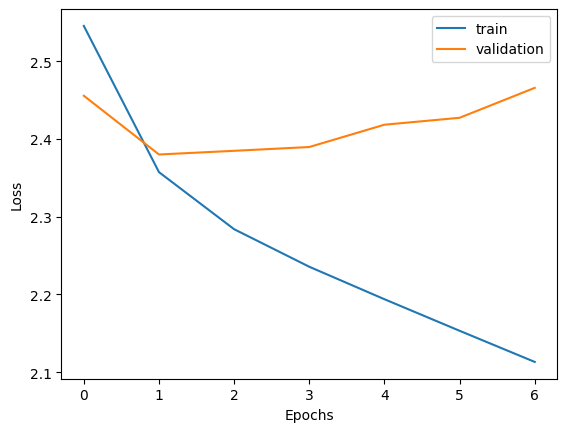

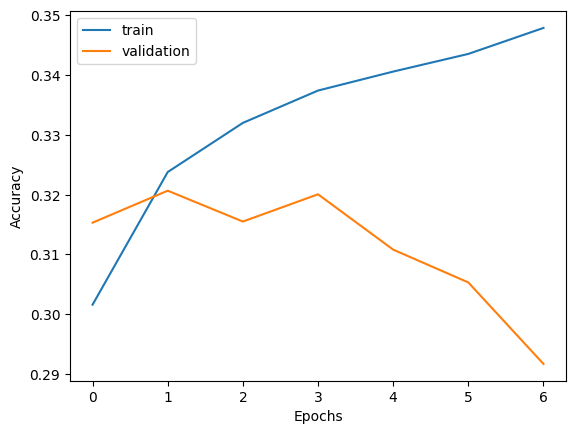

In [27]:
# Mostrar pérdida y precisión en el conjunto de entrenamiento y validación
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Predicciones

In [28]:
# Predecir las emociones en el conjunto de validación
y_pred_probs = model.predict(X_val_padded)

# Obtener las etiquetas originales de las emociones
y_val_labels = label_encoder.inverse_transform(y_val)
emotion_labels = label_encoder.classes_

673/673 [==============================] - 5s 7ms/step


In [29]:
emotion_to_emoji = {
    'admiration': '🤩',
    'amusement': '😄',
    'anger': '😡',
    'annoyance': '😑',
    'approval': '👍',
    'caring': '🥰',
    'confusion': '😕',
    'curiosity': '🤔',
    'desire': '😏',
    'disappointment': '😞',
    'disapproval': '👎',
    'disgust': '🤢',
    'embarrassment': '😳',
    'excitement': '😃',
    'fear': '😨',
    'gratitude': '🙏',
    'joy': '😀',
    'love': '❤️',
    'neutral': '😐',
    'optimism': '😊',
    'realization': '😲',
    'sadness': '😢',
    'surprise': '😮'
}

In [30]:
# Dataframe con texto, emoción real y top 3 de emociones predichas con sus probabilidades
df_results = pd.DataFrame(columns=['text', 'top1', 'top2', 'top3'])
df_results['text'] = X_val

# Obtener las etiquetas de las emociones predichas
top1_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -1]]
top2_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -2]]
top3_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -3]]

# Mapear las emociones a emojis
top1_labels = [emotion_to_emoji[label] for label in top1_labels]
top2_labels = [emotion_to_emoji[label] for label in top2_labels]
top3_labels = [emotion_to_emoji[label] for label in top3_labels]

# Obtener las probabilidades de las emociones predichas
top1_probs = y_pred_probs.max(axis=1) * 100  # Multiplicar por 100 para obtener el porcentaje
top2_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -2]] * 100
top3_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -3]] * 100

# Asignar valores al DataFrame
df_results['top1'] = [f'{label} {prob:.0f}%' for label, prob in zip(top1_labels, top1_probs)]
df_results['top2'] = [f'{label} {prob:.0f}%' for label, prob in zip(top2_labels, top2_probs)]
df_results['top3'] = [f'{label} {prob:.0f}%' for label, prob in zip(top3_labels, top3_probs)]

# Resetear el índice
df_results.reset_index(drop=True, inplace=True)

df_results.head()


,text,top1,top2,top3
0,maybe could put context wa responding someone ...,😐 39%,👎 11%,😞 9%
1,name like picking choosing life work fact work,😐 35%,👍 16%,😲 12%
2,how people eat paper plate theyre bbq,😐 28%,😑 18%,😕 14%
3,thank voice reason people keep screaming vatic...,🙏 43%,😑 27%,😐 15%
4,gotta love trailing minute,❤️ 40%,😐 18%,😀 12%


## Evaluación del modelo

In [31]:
# Transformar las etiquetas a one-hot encoding para calcular métricas
y_val_onehot = np.zeros((len(y_val), num_classes))
y_val_onehot[np.arange(len(y_val)), y_val] = 1

In [38]:
# Cargar el modelo guardado
model_loaded = load_model('models/rnn_glove.h5')

# Predecir las emociones en el conjunto de validación
y_pred = model_loaded.predict(X_val_padded, verbose=0)

In [33]:
# Evaluar el modelo cargado
column_names = [f'{emotion} {emoji}' for emotion, emoji in emotion_to_emoji.items()]
f1_scores = []
precision_scores = []
threshold = 0
for i in range(0, num_classes):
    emotion_prediction = y_pred[:,i]
    emotion_prediction[emotion_prediction>=threshold]=1
    emotion_prediction[emotion_prediction<threshold]=0
    emotion_test = y_val_onehot[:,i]
    precision = precision_score(emotion_test, emotion_prediction)
    recall = recall_score(emotion_test, emotion_prediction)
    f1 = f1_score(emotion_test, emotion_prediction)
    f1_scores.append(f1)
    precision_scores.append(precision)
    print("Emotion: {}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(column_names[i], precision, recall, f1))

Emotion: admiration 🤩, Precision: 0.0594, Recall: 1.0000, F1-measure: 0.1122
Emotion: amusement 😄, Precision: 0.0356, Recall: 1.0000, F1-measure: 0.0687
Emotion: anger 😡, Precision: 0.0329, Recall: 1.0000, F1-measure: 0.0637
Emotion: annoyance 😑, Precision: 0.0621, Recall: 1.0000, F1-measure: 0.1169
Emotion: approval 👍, Precision: 0.0793, Recall: 1.0000, F1-measure: 0.1470
Emotion: caring 🥰, Precision: 0.0230, Recall: 1.0000, F1-measure: 0.0450
Emotion: confusion 😕, Precision: 0.0322, Recall: 1.0000, F1-measure: 0.0623
Emotion: curiosity 🤔, Precision: 0.0343, Recall: 1.0000, F1-measure: 0.0664
Emotion: desire 😏, Precision: 0.0149, Recall: 1.0000, F1-measure: 0.0294
Emotion: disappointment 😞, Precision: 0.0349, Recall: 1.0000, F1-measure: 0.0675
Emotion: disapproval 👎, Precision: 0.0549, Recall: 1.0000, F1-measure: 0.1041
Emotion: disgust 🤢, Precision: 0.0228, Recall: 1.0000, F1-measure: 0.0445
Emotion: embarrassment 😳, Precision: 0.0102, Recall: 1.0000, F1-measure: 0.0202
Emotion: exci

c:\Users\elena\Desktop\ADNE_practicas\ADNE\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129321 (\N{GRINNING FACE WITH STAR EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elena\Desktop\ADNE_practicas\ADNE\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elena\Desktop\ADNE_practicas\ADNE\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129392 (\N{SMILING FACE WITH SMILING EYES AND THREE HEARTS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elena\Desktop\ADNE_practicas\ADNE\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\elena\Desktop\ADNE_practicas\ADNE\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128078

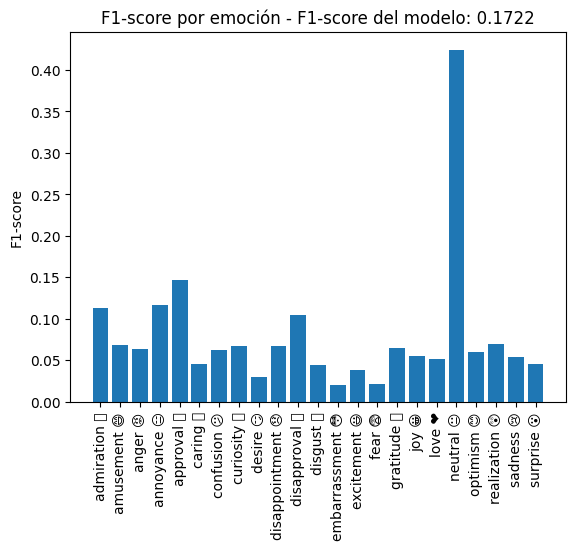

In [34]:
# Gráfico de barras con los F1-scores
fig = plt.figure()
plt.bar(column_names, f1_scores)
plt.xticks(rotation=90)
plt.ylabel('F1-score')
f1_model = f1_score(y_val_onehot, y_pred>threshold, average='weighted') # F1-score ponderado
plt.title('F1-score por emoción - F1-score del modelo: {:.4f}'.format(f1_model))
plt.show()

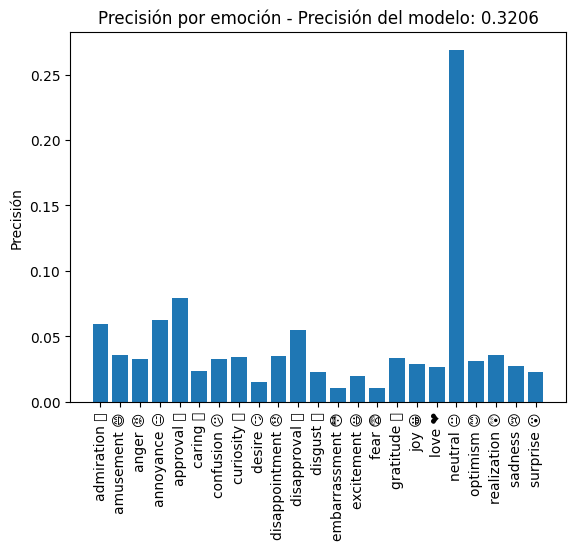

In [35]:
# Graficar precisión por emoción
fig = plt.figure()
plt.bar(column_names, precision_scores)
plt.xticks(rotation=90)
plt.ylabel('Precisión')
_, accuracy = model_loaded.evaluate(X_val_padded, y_val, verbose=0)
plt.title('Precisión por emoción - Precisión del modelo: {:.4f}'.format(accuracy))
plt.show()

El modelo de Red Neuronal Recurrente con GloVe embeddings tiene una **precisión del 32%** en el conjunto de validación y un **F1-score del 17%**.